In [1]:
import os
import findspark

from spark_builder import SparkBuilder
from pyspark.sql.functions import explode, split, col

import yaml
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

os.environ['SPARK_HOME'] = "C:/apps/spark-3.5.1-bin-hadoop3/"
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
#os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'lab'
#os.environ['PYSPARK_PYTHON'] = 'python'
findspark.init()
cfg = yaml.load(open('config.yaml'), Loader=yaml.FullLoader)

In [2]:
with open(".env", "r") as f:
    for line in f:
        k, v = line.rstrip().split('=')
        os.environ[k] = v

In [3]:
url = "jdbc:oracle:thin:@localhost:1521/FREE"
properties = {
    "user": "system",
    "password": os.environ["ORACLE_PWD"],
    "driver": "oracle.jdbc.driver.OracleDriver"
}

In [4]:
#UPLOAD TO DB
spark = SparkBuilder({'spark.app.name': 'Upload_db'}).getSession()

cfg = yaml.load(open('config.yaml'), Loader=yaml.FullLoader)

dataset = spark.read.csv(cfg['dataset']['data_path'], header=True, inferSchema=True, sep='\t')
dataset = dataset.select(cfg['dataset']['filtered_cols'])
dataset = dataset.na.fill(value=0)
print('Input data')
dataset.printSchema()

dataset.write.jdbc(url=url, table=cfg['db']['data_table'], mode="overwrite", properties=properties)
del(dataset)

spark.stop()

Input data
root
 |-- completeness: double (nullable = false)
 |-- energy_100g: double (nullable = false)
 |-- energy-kcal_100g: double (nullable = false)
 |-- carbohydrates_100g: double (nullable = false)
 |-- proteins_100g: double (nullable = false)
 |-- fat_100g: double (nullable = false)
 |-- sugars_100g: double (nullable = false)
 |-- saturated-fat_100g: double (nullable = false)
 |-- salt_100g: double (nullable = false)
 |-- sodium_100g: double (nullable = false)



In [5]:
spark = SparkBuilder({'spark.app.name': 'Clustering'}).getSession()

#cfg = yaml.load(open('config.yaml'), Loader=yaml.FullLoader)

dataset = spark.read.jdbc(url=url, table=cfg['db']['data_table'], properties=properties)
print('Input data')
dataset.printSchema()

vec_assembler = VectorAssembler(inputCols=dataset.columns,
                                outputCol='features')
final_data = vec_assembler.transform(dataset)
print('VectorAssembler')
final_data.select('features').show(5)

scaler = StandardScaler(inputCol="features",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=False)
scalerModel = scaler.fit(final_data)
final_data = scalerModel.transform(final_data)
print('StandardScaler')
final_data.select('scaledFeatures').show(5)

evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')
kmeans = KMeans(featuresCol='scaledFeatures', k=12, seed=42)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)
score = evaluator.evaluate(predictions)

predictions.select(['prediction']).write.jdbc(url=url, table=cfg['db']['pred_table'], mode='append', properties=properties)

spark.stop()

Input data
root
 |-- completeness: decimal(19,4) (nullable = true)
 |-- energy_100g: decimal(19,4) (nullable = true)
 |-- energy-kcal_100g: decimal(19,4) (nullable = true)
 |-- carbohydrates_100g: decimal(19,4) (nullable = true)
 |-- proteins_100g: decimal(19,4) (nullable = true)
 |-- fat_100g: decimal(19,4) (nullable = true)
 |-- sugars_100g: decimal(19,4) (nullable = true)
 |-- saturated-fat_100g: decimal(19,4) (nullable = true)
 |-- salt_100g: decimal(19,4) (nullable = true)
 |-- sodium_100g: decimal(19,4) (nullable = true)

VectorAssembler
+--------------------+
|            features|
+--------------------+
|    (10,[0],[0.375])|
|   (10,[0],[0.4625])|
|[0.2,448.0,107.0,...|
|[0.375,174.0,41.6...|
|(10,[0,1,2,3,6],[...|
+--------------------+
only showing top 5 rows

StandardScaler
+--------------------+
|      scaledFeatures|
+--------------------+
|(10,[0],[2.213270...|
|(10,[0],[2.729700...|
|[1.18041083366837...|
|[2.21327031312821...|
|(10,[0,1,2,3,6],[...|
+------------------

In [6]:
spark = SparkBuilder({'spark.app.name': 'Read predictions'}).getSession()
spark.read.jdbc(url=url, table=cfg['db']['pred_table'], properties=properties).show()
spark.stop()

+----------+
|prediction|
+----------+
|         5|
|         5|
|         4|
|         5|
|         5|
|         4|
|         4|
|         4|
|         4|
|         4|
|         5|
|         4|
|         7|
|         7|
|         0|
|         5|
|         5|
|         0|
|         4|
|         0|
+----------+
only showing top 20 rows



In [10]:
spark = SparkBuilder({'spark.app.name': 'Clustering'}).getSession()

cfg = yaml.load(open('config.yaml'), Loader=yaml.FullLoader)

dataset = spark.read.csv(cfg['dataset']['data_path'], header=True, inferSchema=True, sep='\t')
dataset = dataset.select(cfg['dataset']['filtered_cols'])
dataset = dataset.na.fill(value=0)
print('Input data')
dataset.printSchema()

vec_assembler = VectorAssembler(inputCols=dataset.columns,
                                outputCol='features')
final_data = vec_assembler.transform(dataset)
print('VectorAssembler')
final_data.select('features').show(5)

scaler = StandardScaler(inputCol="features",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=False)
scalerModel = scaler.fit(final_data)
final_data = scalerModel.transform(final_data)
print('StandardScaler')
final_data.select('scaledFeatures').show(5)

silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')
ks = range(2, 15)
for i in ks:
    kmeans = KMeans(featuresCol='scaledFeatures', k=i, seed=42)
    model = kmeans.fit(final_data)
    predictions = model.transform(final_data)
    score = evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =', i, 'is', score)


plt.plot(ks,silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

spark.stop()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "C:\Users\stfu_\OneDrive\Desktop\BigData\Spark\base\.venv\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
RuntimeError: reentrant call inside <_io.BufferedReader name=1620>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\stfu_\OneDrive\Desktop\BigData\Spark\base\.venv\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "C:\Users\stfu_\OneDrive\Desktop\BigData\Spark\base\.venv\lib\site-packages\py4j\clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "C:\Users\stfu_\OneDrive\Desktop\BigData\Spark\base\.venv\lib\site-pac

Py4JError: An error occurred while calling o131.csv

In [ ]:
# from db_connection import DB_Connection
# self.connection = DB_Connection()
# #self.connection.append_df(pd.DataFrame(data={"y_real":y_pred}), self.log_db_table_name)

In [2]:
url = "jdbc:oracle:<database_type>://<hostname>:<port>/<database_name>"
properties = {
    "user": "<username>",
    "password": "<password>",
    "driver": "oracle.jdbc.driver.OracleDriver"
}

table_name = "<table_name>"
df = spark.read.jdbc(url=url, table=table_name, properties=properties)

mode = "overwrite"
df.write.jdbc(url=url, table=table_name, mode=mode, properties=properties)

NameError: name 'spark' is not defined

In [2]:
spark = SparkBuilder({'spark.app.name': 'Show'}).getSession()

data = [("Alice", 25), ("Bob", 30), ("Charlie", 35)]
df = spark.createDataFrame(data, ["Name", "Age"])
df.show()

+-------+---+
|   Name|Age|
+-------+---+
|  Alice| 25|
|    Bob| 30|
|Charlie| 35|
+-------+---+



In [5]:
url = "jdbc:oracle:thin:@localhost:1521/FREE"
properties = {
    "user": "system",
    "password": '12345',
    "driver": "oracle.jdbc.driver.OracleDriver"
}

table_name = "test"
#df = spark.read.jdbc(url=url, table=table_name, properties=properties)

mode = "overwrite"
df.write.jdbc(url=url, table=table_name, mode=mode, properties=properties)

In [6]:
df_new = spark.read.jdbc(url=url, table=table_name, properties=properties)

In [7]:
df_new.show()

+-------+---+
|   Name|Age|
+-------+---+
|    Bob| 30|
|  Alice| 25|
|Charlie| 35|
+-------+---+



In [8]:
spark.stop()

In [ ]:
spark = SparkBuilder({'spark.app.name': 'Word-count'}).getSession()

df = spark.read.text('input.txt')

df_count = (
    df.withColumn('word', explode(split(col('value'), ' ')))
        .groupBy('word')
        .count()
        .sort('count', ascending=False)
)

df_count.show()

spark.stop()

In [ ]:
#findspark.init()
spark = SparkBuilder({'spark.app.name': 'Show'}).getSession()
#findspark.init()

data = [("Alice", 25), ("Bob", 30), ("Charlie", 35)]
df = spark.createDataFrame(data, ["Name", "Age"])
df.show()

spark.stop()

In [2]:
spark = SparkBuilder({'spark.app.name': 'Word-count'}).getSession()

df = spark.read.text('input.txt')

df_count = (
    df.withColumn('word', explode(split(col('value'), ' ')))
        .groupBy('word')
        .count()
        .sort('count', ascending=False)
)

df_count.show()

spark.stop()

+----------+-----+
|      word|count|
+----------+-----+
|       the|    6|
|     Lorem|    4|
|        of|    4|
|       and|    3|
|     Ipsum|    3|
|      with|    2|
|        It|    2|
|     dummy|    2|
|      type|    2|
|      text|    2|
|         a|    2|
|       has|    2|
|publishing|    1|
|unchanged.|    1|
|    sheets|    1|
|   desktop|    1|
|       not|    1|
|     1960s|    1|
|  Letraset|    1|
|    Ipsum.|    1|
+----------+-----+
only showing top 20 rows



In [3]:
#findspark.init()
spark = SparkBuilder({'spark.app.name': 'Show'}).getSession()
#findspark.init()

data = [("Alice", 25), ("Bob", 30), ("Charlie", 35)]
df = spark.createDataFrame(data, ["Name", "Age"])
df.show()

spark.stop()

+-------+---+
|   Name|Age|
+-------+---+
|  Alice| 25|
|    Bob| 30|
|Charlie| 35|
+-------+---+



Input data
root
 |-- completeness: double (nullable = false)
 |-- energy_100g: double (nullable = false)
 |-- energy-kcal_100g: double (nullable = false)
 |-- carbohydrates_100g: double (nullable = false)
 |-- proteins_100g: double (nullable = false)
 |-- fat_100g: double (nullable = false)
 |-- sugars_100g: double (nullable = false)
 |-- saturated-fat_100g: double (nullable = false)
 |-- salt_100g: double (nullable = false)
 |-- sodium_100g: double (nullable = false)

VectorAssembler
+--------------------+
|            features|
+--------------------+
|      (10,[0],[0.3])|
|[0.2625,690.0,165...|
|[0.4875,0.0,0.0,9...|
|[0.575,238.0,57.0...|
|[0.275,1569.0,375...|
+--------------------+
only showing top 5 rows

StandardScaler
+--------------------+
|      scaledFeatures|
+--------------------+
|(10,[0],[1.770616...|
|[1.54928925370272...|
|[2.87725147116219...|
|[3.39368122239643...|
|[1.62306493245047...|
+--------------------+
only showing top 5 rows

Silhouette Score for k = 2 is 0

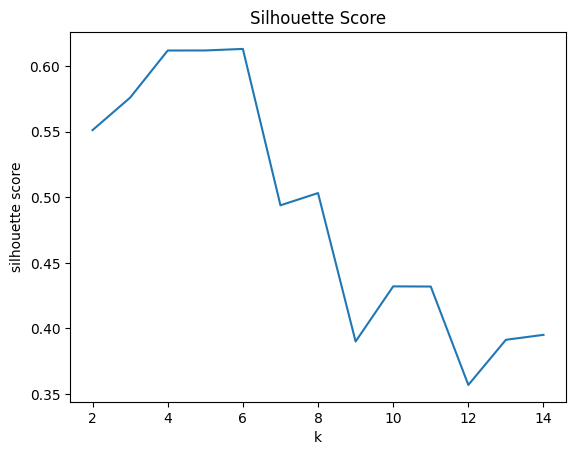

In [13]:
spark = SparkBuilder({'spark.app.name': 'Clustering'}).getSession()

cfg = yaml.load(open('config.yaml'), Loader=yaml.FullLoader)

dataset = spark.read.csv(cfg['dataset']['data_path'], header=True, inferSchema=True, sep='\t')
dataset = dataset.select(cfg['dataset']['filtered_cols'])
dataset = dataset.na.fill(value=0)
print('Input data')
dataset.printSchema()

vec_assembler = VectorAssembler(inputCols=dataset.columns,
                                outputCol='features')
final_data = vec_assembler.transform(dataset)
print('VectorAssembler')
final_data.select('features').show(5)

scaler = StandardScaler(inputCol="features",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=False)
scalerModel = scaler.fit(final_data)
final_data = scalerModel.transform(final_data)
print('StandardScaler')
final_data.select('scaledFeatures').show(5)

silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')
ks = range(2, 15)
for i in ks:
    kmeans = KMeans(featuresCol='scaledFeatures', k=i, seed=42)
    model = kmeans.fit(final_data)
    predictions = model.transform(final_data)
    score = evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =', i, 'is', score)


plt.plot(ks,silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

spark.stop()

In [43]:
dataset = spark.read.csv(cfg['dataset']['data_path'], header=True, inferSchema=True, sep='\t')
dataset = dataset.select(cfg['dataset']['filtered_cols'])
dataset = dataset.na.fill(value=0)
dataset.printSchema()

root
 |-- completeness: double (nullable = false)
 |-- energy_100g: double (nullable = false)
 |-- energy-kcal_100g: double (nullable = false)
 |-- carbohydrates_100g: double (nullable = false)
 |-- proteins_100g: double (nullable = false)
 |-- fat_100g: double (nullable = false)
 |-- sugars_100g: double (nullable = false)
 |-- saturated-fat_100g: double (nullable = false)



In [44]:
vec_assembler = VectorAssembler(inputCols=dataset.columns,
                                outputCol='features')
final_data = vec_assembler.transform(dataset)
final_data.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|       (8,[0],[0.3])|
|[0.2625,690.0,165...|
|[0.4875,0.0,0.0,9...|
|[0.575,238.0,57.0...|
|[0.275,1569.0,375...|
+--------------------+
only showing top 5 rows



In [45]:
scaler = StandardScaler(inputCol="features",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=False)

scalerModel = scaler.fit(final_data)
final_data = scalerModel.transform(final_data)
final_data.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|(8,[0],[1.7706162...|
|[1.54928925370272...|
|[2.87725147116219...|
|[3.39368122239643...|
|[1.62306493245047...|
+--------------------+
only showing top 5 rows



In [48]:
silhouette_score = []

evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')

for i in range(2, 10):
    kmeans = KMeans(featuresCol='scaledFeatures', k=i)
    model = kmeans.fit(final_data)
    predictions = model.transform(final_data)
    score = evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =', i, 'is', score)

Silhouette Score for k = 2 is 0.999617103142301
Silhouette Score for k = 3 is 0.99921644271818
Silhouette Score for k = 4 is 0.6276416849574148
Silhouette Score for k = 5 is 0.5038254029969851
Silhouette Score for k = 6 is 0.35370991910689414
Silhouette Score for k = 7 is 0.37035634445849425
Silhouette Score for k = 8 is 0.415258808687113
Silhouette Score for k = 9 is 0.5057858206653499


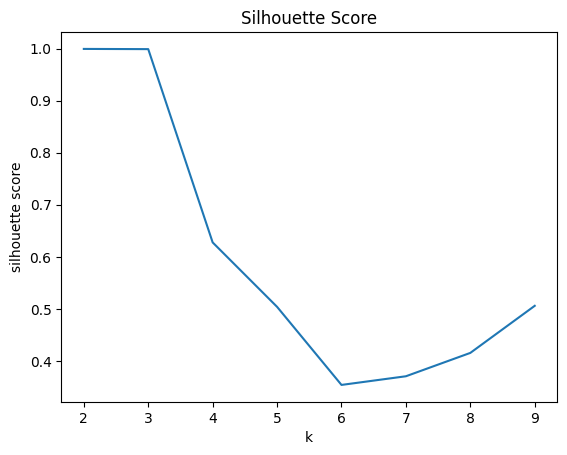

In [49]:
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [75]:
spark.stop()

In [11]:
import pandas as pd

df = pd.read_csv("./truncated.csv", sep='\t', )
df = df.loc[:, df.dtypes == float]
cols = df.isnull().sum().sort_values()[:12]\
    .drop(labels=['last_updated_t', 'last_image_t'])\
    .index.to_list()
cols

C:\Users\stfu_\AppData\Local\Temp\ipykernel_10104\3774533282.py:3: DtypeWarning: Columns (0,17,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./truncated.csv", sep='\t', )


['completeness',
 'energy_100g',
 'energy-kcal_100g',
 'carbohydrates_100g',
 'proteins_100g',
 'fat_100g',
 'sugars_100g',
 'saturated-fat_100g',
 'salt_100g',
 'sodium_100g']